# IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter

!pip install lime --quiet
import lime
from lime.lime_tabular import LimeTabularExplainer



# CARREGANDO DATASET

In [ ]:
# Utilizei a base pelo Kaggle pois o disponibilizado no enunciado do AT estava faltando linhas

file_path = "diamonds.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shivam2503/diamonds",
  file_path,
)

print("Primeiras linhas do dataset:")
display(df.head())

print("\nColunas do dataset:", df.columns)
print("\nValores únicos da variável alvo 'cut':", df['cut'].unique())

Using Colab cache for faster access to the 'diamonds' dataset.
Primeiras linhas do dataset:


Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75


Colunas do dataset: Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

Valores únicos da variável alvo 'cut': ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']


# PRE-PROCESSAMENTO

Contagem por classe:
cut
0    21551
1    13791
3    12082
4     4906
5     1610
Name: count, dtype: int64

Porcentagem por classe:
cut
0    39.95
1    25.57
3    22.40
4     9.10
5     2.98
Name: proportion, dtype: float64


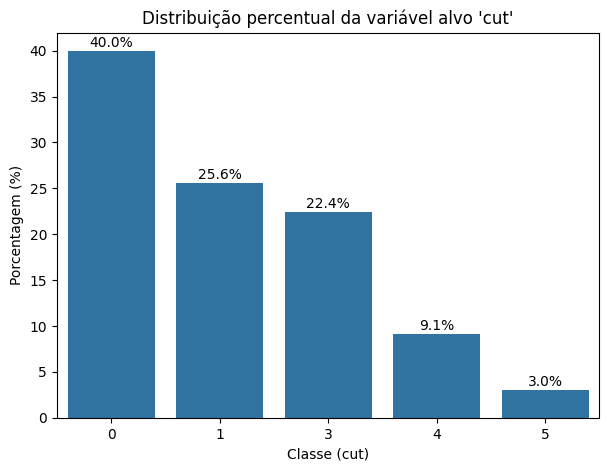

In [ ]:
# Criar dummies de 'clarity' e 'color'
cols_to_dummy = [col for col in ['clarity', 'color'] if col in df.columns]
df = pd.get_dummies(df, columns=cols_to_dummy, prefix=cols_to_dummy)

# Recodificar variável alvo 'cut'
cut_map = {'Ideal':0, 'Premium':1, 'Very Good':3, 'Good':4, 'Fair':5}
df['cut'] = df['cut'].map(cut_map)

# Separar X e y
X = df.drop(['cut', 'Unnamed: 0'], axis=1)
y = df['cut']

print("Contagem por classe:")
print(y.value_counts())

print("\nPorcentagem por classe:")
print((y.value_counts(normalize=True) * 100).round(2))

# Gráfico em porcentagem com rótulos
pct = y.value_counts(normalize=True).sort_index() * 100
plt.figure(figsize=(7,5))
sns.barplot(x=pct.index, y=pct.values)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Classe (cut)")
plt.title("Distribuição percentual da variável alvo 'cut'")
for i, v in enumerate(pct.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.show()


# SEPARANDO CONJUNTOS DE TREINO E TESTE

In [ ]:
# Criar scaler
scaler = StandardScaler()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Aplicar escalonamento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Treino escalonado:", X_train_scaled.shape)
print("Teste escalonado:", X_test_scaled.shape)


Treino escalonado: (40455, 22)
Teste escalonado: (13485, 22)


# ÁRVORE DE DECISÃO

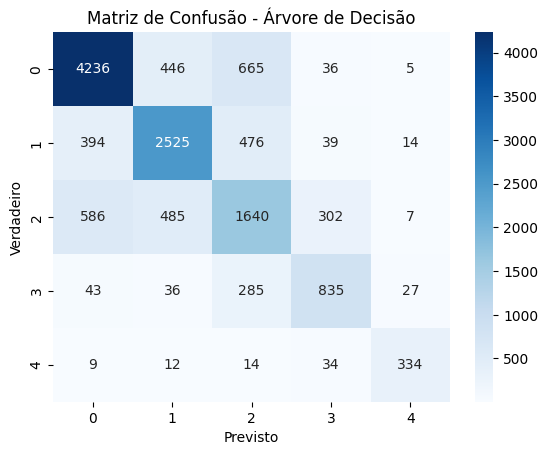

Relatório de classificação - Árvore de Decisão
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      5388
           1       0.72      0.73      0.73      3448
           3       0.53      0.54      0.54      3020
           4       0.67      0.68      0.68      1226
           5       0.86      0.83      0.85       403

    accuracy                           0.71     13485
   macro avg       0.72      0.71      0.72     13485
weighted avg       0.71      0.71      0.71     13485



In [ ]:
# Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Previsão
y_pred_dt = dt.predict(X_test)

# Matriz de confusão
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

# Relatório de classificação
print("Relatório de classificação - Árvore de Decisão")
print(classification_report(y_test, y_pred_dt))


# RANDOM FOREST

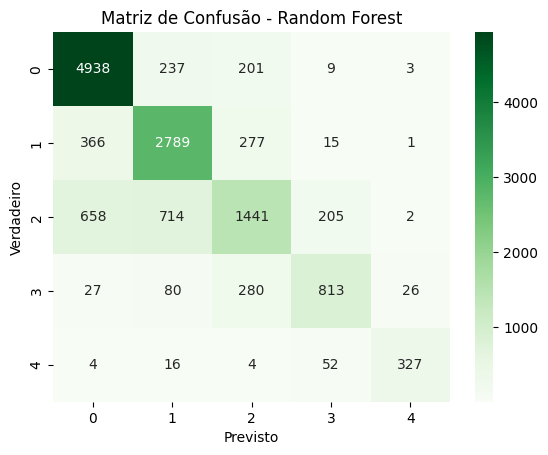

Relatório de classificação - Random Forest
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      5388
           1       0.73      0.81      0.77      3448
           3       0.65      0.48      0.55      3020
           4       0.74      0.66      0.70      1226
           5       0.91      0.81      0.86       403

    accuracy                           0.76     13485
   macro avg       0.77      0.74      0.75     13485
weighted avg       0.76      0.76      0.76     13485



In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Previsão
y_pred_rf = rf.predict(X_test)

# Matriz de confusão
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# Relatório de classificação
print("Relatório de classificação - Random Forest")
print(classification_report(y_test, y_pred_rf))



# GRIDSEARCH RANDOM FOREST

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Melhor combinação RF: {'criterion': 'gini', 'max_depth': None, 'max_features': None}
Melhor acurácia no treino (CV): 0.7819305401062909


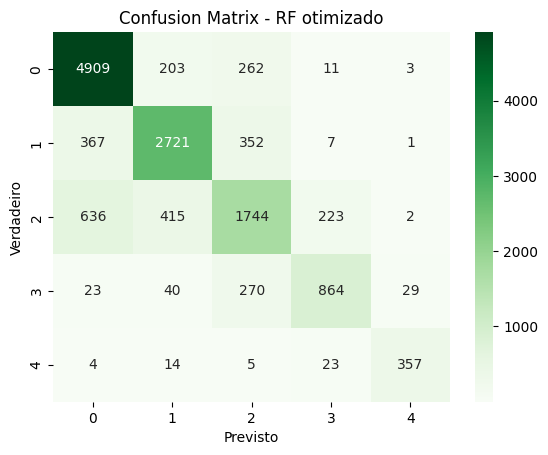

Relatório Random Forest otimizado:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      5388
           1       0.80      0.79      0.80      3448
           3       0.66      0.58      0.62      3020
           4       0.77      0.70      0.73      1226
           5       0.91      0.89      0.90       403

    accuracy                           0.79     13485
   macro avg       0.79      0.77      0.78     13485
weighted avg       0.78      0.79      0.78     13485



In [ ]:
# Definir parâmetros
param_grid_rf = {
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, None],
    "max_features": ["sqrt", "log2", None]
}

# GridSearch
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print("Melhor combinação RF:", grid_rf.best_params_)
print("Melhor acurácia no treino (CV):", grid_rf.best_score_)

# Avaliação no teste
y_pred_rf_best = grid_rf.predict(X_test)
cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
sns.heatmap(cm_rf_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - RF otimizado")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Relatório de classificação
print("Relatório Random Forest otimizado:\n")
print(classification_report(y_test, y_pred_rf_best))


Escolhi otimizar os parâmetros criterion, max_depth e max_features porque eles têm impacto direto no equilíbrio entre viés e variância do modelo. O parâmetro criterion permite comparar funções de impureza distintas na escolha dos splits, max_depth controla a complexidade de cada árvore, prevenindo overfitting em árvores muito profundas e max_features influencia a diversidade entre as árvores da floresta, ajudando a melhorar a capacidade de generalização do modelo.

# XGBOOST

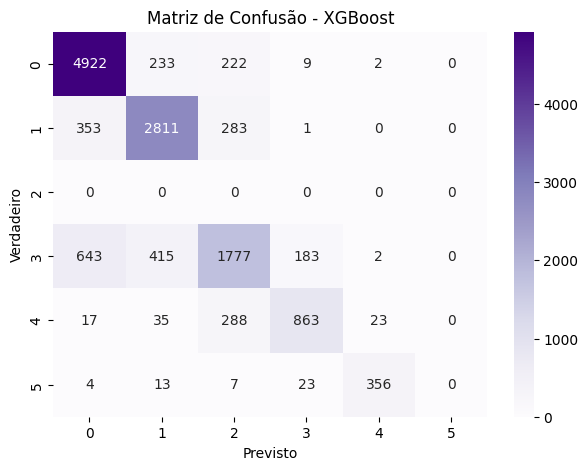

Relatório de classificação - XGBoost
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      5388
           1       0.80      0.82      0.81      3448
           3       0.69      0.59      0.63      3020
           4       0.80      0.70      0.75      1226
           5       0.93      0.88      0.91       403

    accuracy                           0.80     13485
   macro avg       0.81      0.78      0.79     13485
weighted avg       0.79      0.80      0.79     13485



In [ ]:
# Criar um label encoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_enc)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_orig = le.inverse_transform(y_pred_xgb)  # volta para 0,1,3,4,5

# Matriz de confusão
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(7,5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title("Matriz de Confusão - XGBoost")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Relatório de classificação
print("Relatório de classificação - XGBoost")
print(classification_report(y_test, y_pred_xgb_orig))

# SVM

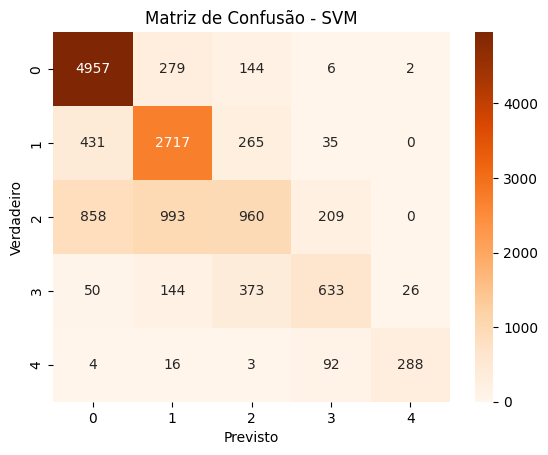

Relatório de classificação - SVM
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      5388
           1       0.65      0.79      0.72      3448
           3       0.55      0.32      0.40      3020
           4       0.65      0.52      0.58      1226
           5       0.91      0.71      0.80       403

    accuracy                           0.71     13485
   macro avg       0.71      0.65      0.67     13485
weighted avg       0.69      0.71      0.69     13485



In [ ]:
# SVM padrão
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Previsão
y_pred_svm = svm_model.predict(X_test_scaled)

# Matriz de confusão opcional
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusão - SVM")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Relatório de classificação
print("Relatório de classificação - SVM")
print(classification_report(y_test, y_pred_svm))


# GRIDSEARCH SVM

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Melhores parâmetros SVM: {'C': 10, 'kernel': 'rbf'}
Melhor acurácia no treino (CV): 0.7407984179953034


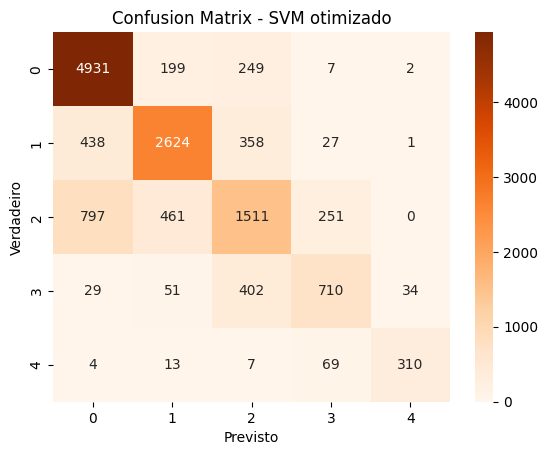

Relatório SVM otimizado:

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      5388
           1       0.78      0.76      0.77      3448
           3       0.60      0.50      0.54      3020
           4       0.67      0.58      0.62      1226
           5       0.89      0.77      0.83       403

    accuracy                           0.75     13485
   macro avg       0.75      0.70      0.72     13485
weighted avg       0.74      0.75      0.74     13485



In [ ]:
# SVM base
svm_model = SVC(probability=True, random_state=42)

# Grid de parâmetros
param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}

# GridSearch
grid_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid_svm.fit(X_train_scaled, y_train)

# Melhor configuração
print("Melhores parâmetros SVM:", grid_svm.best_params_)
print("Melhor acurácia no treino (CV):", grid_svm.best_score_)

# Previsão no teste
y_pred_svm_best = grid_svm.predict(X_test_scaled)

# Matriz de confusão
cm_svm_best = confusion_matrix(y_test, y_pred_svm_best)
sns.heatmap(cm_svm_best, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - SVM otimizado")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

print("Relatório SVM otimizado:\n")
print(classification_report(y_test, y_pred_svm_best))

# FEATURE IMPORTANCE DO MELHOR RF

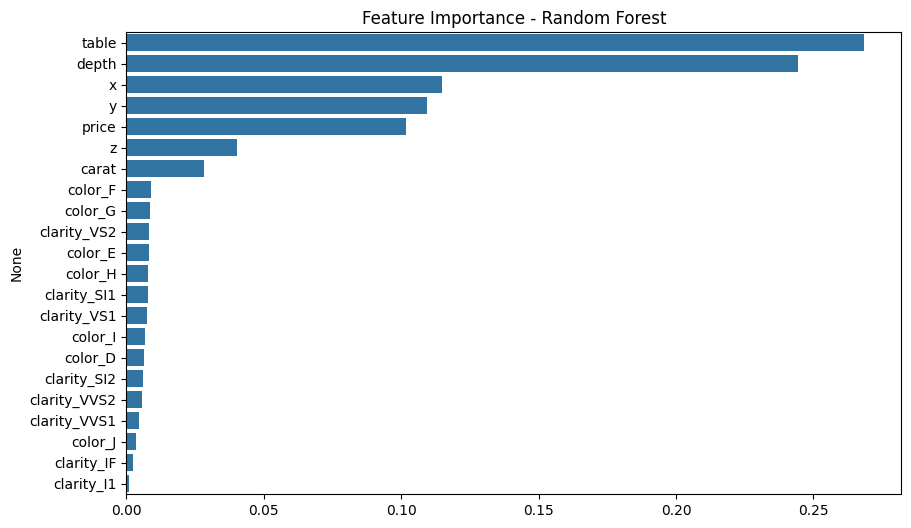

Três variáveis mais importantes: Index(['table', 'depth', 'x'], dtype='object')


In [ ]:
# Melhor modelo RF direto
best_rf_model = grid_rf.best_estimator_

# Importância das features
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Visualização
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importance - Random Forest")
plt.show()

# Top 3 features
top3_features = feature_names[indices][:3]
print("Três variáveis mais importantes:", top3_features)

Essas três variáveis tiveram maior impacto na classificação do corte dos diamantes. Table e depth representam proporções físicas da pedra, enquanto x indica o comprimento. Isso mostra que as características geométricas do diamante são determinantes para definir seu corte, mais até do que a cor ou clareza isoladamente.

# LIME PARA DUAS OBSERVAÇÕES DO TESTE

In [ ]:
# Criar o explainer baseado no treino
explainer = LimeTabularExplainer(training_data=X_train.values, feature_names=X.columns, class_names=[str(c) for c in np.unique(y_train)], mode="classification")

# Seleciona 2 observações aleatórias do teste
obs_positions = np.random.choice(range(X_test.shape[0]), 2, replace=False)

for i, pos in enumerate(obs_positions):
    obs = X_test.iloc[[pos]]

    # Explicação com LIME
    exp = explainer.explain_instance(obs.values[0], best_rf_model.predict_proba, num_features=5)

    print(f"\n=== Observação {i+1} (posição {pos} no X_test) ===")
    display(obs)
    exp.show_in_notebook(show_table=True)

    # Dois fatores mais influentes
    top_factors = exp.as_list()[:2]
    print("Dois fatores mais influentes nesta classificação:")
    for feature, weight in top_factors:
        sinal = "positivo" if weight > 0 else "negativo"
        print(f"- {feature} (impacto {sinal}, peso {weight:.2f})")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Observação 1 (posição 6128 no X_test) ===


carat  depth  table  price     x     y    z  clarity_I1  clarity_IF  \
47191   0.51   62.3   56.0   1837  5.14  5.13  3.2       False       False   

       clarity_SI1  ...  clarity_VS2  clarity_VVS1  clarity_VVS2  color_D  \
47191        False  ...        False         False         False    False   

       color_E  color_F  color_G  color_H  color_I  color_J  
47191     True    False    False    False    False    False  

[1 rows x 22 columns]

Dois fatores mais influentes nesta classificação:
- table <= 56.00 (impacto negativo, peso -0.10)
- 4.71 < x <= 5.70 (impacto negativo, peso -0.09)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



=== Observação 2 (posição 12233 no X_test) ===


carat  depth  table  price     x     y     z  clarity_I1  clarity_IF  \
5266   1.03   63.7   56.0   3795  6.42  6.35  4.07       False       False   

      clarity_SI1  ...  clarity_VS2  clarity_VVS1  clarity_VVS2  color_D  \
5266        False  ...         True         False         False    False   

      color_E  color_F  color_G  color_H  color_I  color_J  
5266    False    False    False    False    False     True  

[1 rows x 22 columns]

Dois fatores mais influentes nesta classificação:
- depth > 62.50 (impacto negativo, peso -0.26)
- table <= 56.00 (impacto negativo, peso -0.08)


Obs 1: O modelo classificou a amostra majoritariamente na classe 0 (96%) e os fatores que mais influenciaram foram a tabela baixa (table <= 56) e a largura x na faixa 4.71–5.70, que puxaram a probabilidade contra outras classes.


Obs 2: O modelo classificou a amostra principalmente na classe 4 (72%) e os fatores depth > 62.5 e table <= 56 foram decisivos para essa atribuição, indicando que profundidade e tabela tiveram papel central no resultado.